# PPO

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import jax.numpy as jnp

from extravaganza.dynamical_systems import PPOGym

from extravaganza.lifters import NoLift, RandomLift, LearnedLift
from extravaganza.sysid import SysID
from extravaganza.controllers import LiftedBPC, ConstantController
from extravaganza.rescalers import ADAM, D_ADAM, DoWG
from experiments import run_experiment, ylim

# seeds for randomness. setting to `None` uses random seeds
SYSTEM_SEED = None
CONTROLLER_SEED = None
LIFTER_AND_SYSID_SEED = None

## System
Here, we tune the parameters of a PPO algorithm learning on an OpenAI Gym environment. The PPO update step is
$$L^{CLIP}(\theta) = \mathbb{E} \left[ \min\left(r(\theta, \theta_{\text{old}}, s_t, a_t) \cdot \hat{A}_t, \text{clip}\left(r(\theta, \theta_{\text{old}}, s_t, a_t), 1 - \epsilon, 1 + \epsilon\right) \cdot \hat{A}_t\right)\right],
$$
and so we can tune the clip parameter $\epsilon$ in addition to learning rate $\eta$ and more.

We play on games like `CartPole`.

## Hyperparameters

In [2]:
# --------------------------------------------------------------------------------------
# ------------------------    EXPERIMENT HYPERPARAMETERS    ----------------------------
# --------------------------------------------------------------------------------------

num_trials = 1
T = 800  # total timesteps
T0 = 20  # number of timesteps to just sysid for our methods
reset_every = 20000  # how often to reset the system
wordy = True  # whether to print some things

# --------------------------------------------------------------------------------------
# --------------------------    SYSTEM HYPERPARAMETERS    ------------------------------
# --------------------------------------------------------------------------------------

du = 1  # control dim
initial_eps_clip = 0.2  # initial value for eps
def apply_control(control, sys): sys.ppo.eps_clip = initial_eps_clip + control.item()

env_name = 'CartPole-v1'  
# env_name = 'MountainCarContinuous-v0'
continuous_action_space = False

system_args = {
    'apply_control': apply_control,
    'control_dim': du,
    'env_name': env_name,
    'lr_actor': 0.0003,
    'lr_critic': 0.001,
    'eps_clip': initial_eps_clip,
    'continuous_action_space': continuous_action_space,
    'gamma': 0.98,
    'repeat': 10,
    'render': False,
    'seed': SYSTEM_SEED,
}
make_system = lambda : PPOGym(**system_args)

# --------------------------------------------------------------------------------------
# ------------------------    CONTROLLER HYPERPARAMETERS    ----------------------------
# --------------------------------------------------------------------------------------

h = 10  # controller memory length (# of w's to use on inference)
hh = 10  # history length of the cost/control histories
lift_dim = 20  # dimension to lift to

m_update_rescaler = lambda : ADAM(0.001, betas=(0.9, 0.999))
m0_update_rescaler = lambda : ADAM(0.001, betas=(0.9, 0.999))
k_update_rescaler = lambda : ADAM(0.001, betas=(0.9, 0.999))

lifted_bpc_args = {
    'h': h,
    'method': 'REINFORCE',
    'initial_scales': (0.01, 0.01, 0.01),  # M, M0, K   (uses M0's scale for REINFORCE)
    'rescalers': (m_update_rescaler, m0_update_rescaler, k_update_rescaler),
    'T0': T0,
    'bounds': (-initial_eps_clip, 1 - initial_eps_clip),
    'initial_u': jnp.zeros(du),
    'decay_scales': False,
    'use_sigmoid': True,
    'use_K_from_sysid': False,
    'seed': CONTROLLER_SEED
}

make_controllers = {
    'Zero': lambda sys: ConstantController(0, du),
    'No Lift': lambda sys: LiftedBPC(lifter=NoLift(hh, du, LIFTER_AND_SYSID_SEED), sysid=SysID(sysid_method, du, hh, sysid_scale, LIFTER_AND_SYSID_SEED), **lifted_bpc_args),
    'Random Lift': lambda sys: LiftedBPC(lifter=RandomLift(hh, du, lift_dim, learned_lift_args['depth'], LIFTER_AND_SYSID_SEED), sysid=SysID(sysid_method, du, lift_dim, sysid_scale, LIFTER_AND_SYSID_SEED), **lifted_bpc_args),
    'Learned Lift': lambda sys: LiftedBPC(lifter=LearnedLift(hh, du, lift_dim, scale=sysid_scale, **learned_lift_args), **lifted_bpc_args)
}

# --------------------------------------------------------------------------------------
# ------------------------    LIFT/SYSID HYPERPARAMETERS    ----------------------------
# --------------------------------------------------------------------------------------

sysid_method = 'regression'
sysid_scale = 0.1

learned_lift_args = {
    'lift_lr': 0.001,
    'sysid_lr': 0.001,
    'cost_lr': 0.001,
    'depth': 4,
    'buffer_maxlen': int(1e6),
    'num_epochs': 75,
    'batch_size': 64,
    'seed': LIFTER_AND_SYSID_SEED
}

## Plotting
We keep track of the useful information through `Stats` objects, which can `register()` a variable to keep track of (which it does via calls to `update()`) and which can be aggregated via `Stats.aggregate()` for mean and variance statistics. 

We define below a plotting arrangement that plots all the desired quantities from both the system and controller.

In [3]:
def plot_ppo(all_stats):
    # clear plot and calc nrows
    plt.clf()
    n = 5
    nrows = n + (len(all_stats) + 1) // 2
    fig, ax = plt.subplots(nrows, 2, figsize=(16, 4 * nrows))

    # plot system and controller stats
    for i, (method, stats) in enumerate(all_stats.items()):
        if stats is None: 
            print('{} had no stats'.format(method))
            continue
        stats.plot(ax[0, 0], 'eps_clip', label=method)
#         stats.plot(ax[0, 1], 'ws', label=method)
        stats.plot(ax[1, 0], 'us', label=method)
        stats.plot(ax[2, 0], 'rewards', label=method)
        stats.plot(ax[2, 1], 'avg rewards', label=method)
    
        stats.plot(ax[3, 0], '||A||_op', label=method)
        stats.plot(ax[3, 1], '||B||_F', label=method)
        stats.plot(ax[4, 0], '||A-BK||_op', label=method)
        stats.plot(ax[4, 1], 'lifter losses', label=method)
        i_ax = ax[n + i // 2, i % 2]
        stats.plot(ax[0, 1], 'disturbances', label=method)
        stats.plot(i_ax, 'K @ state', label='K @ state')
        stats.plot(i_ax, 'M \cdot w', label='M \cdot w')
        stats.plot(i_ax, 'M0', label='M0')
        i_ax.set_title('u decomp for {}'.format(method))
        i_ax.legend()

    # set titles and legends and limits and such
    # (note: `ylim()` is so useful! because sometimes one thing blows up and then autoscale messes up all plots)
    _ax = ax[0, 0]; _ax.set_title('state'); _ax.legend(); ylim(_ax, -1, 2)
    _ax = ax[0, 1]; _ax.set_title('disturbances'); _ax.legend(); ylim(_ax, -5, 5)
    _ax = ax[1, 0]; _ax.set_title('controls'); _ax.legend(); ylim(_ax, -3, 3)
    
    _ax = ax[2, 0]; _ax.set_title('instantaneous rewards'); _ax.legend()
    _ax = ax[2, 1]; _ax.set_title('avg rewards'); _ax.legend()    
    
    _ax = ax[3, 0]; _ax.set_title('||A||_op'); _ax.legend()
    _ax = ax[3, 1]; _ax.set_title('||B||_F'); _ax.legend()
    
    _ax = ax[4, 0]; _ax.set_title('||A-BK||_op'); _ax.legend()
    _ax = ax[4, 1]; _ax.set_title('lifter losses'); _ax.legend()
    pass

## actually run the thing :)

--------------------------------------------------
----------------- TRIAL 0 -----------------------
--------------------------------------------------

testing Zero
registering running average of rewards


  1%|▋                                                                                    | 7/800 [00:00<00:11, 66.74it/s, control=0, cost=-14]

reset!


100%|███████████████████████████████████████████████████████████████████████████████████| 800/800 [00:08<00:00, 99.19it/s, control=0, cost=-20]



testing No Lift
registering running average of rewards


  0%|                                                                                                                  | 0/800 [00:00<?, ?it/s]

reset!


  1%|█                                                                                 | 10/800 [00:00<00:19, 40.38it/s, control=0.1, cost=-10]

  3%|██▍                                                                             | 24/800 [00:01<00:24, 31.29it/s, control=-.142, cost=-28]/Users/evandigiorno/Desktop/extravaganza/env/lib/python3.10/site-packages/extravaganza/utils.py:130: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-t))
100%|███████████████████████████████████████████████████████████████████████████████| 800/800 [00:18<00:00, 43.16it/s, control=0.795, cost=-50]



testing Random Lift
registering running average of rewards


  1%|█                                                                                 | 10/800 [00:00<00:08, 93.68it/s, control=-.1, cost=-10]

reset!


  1%|█                                                                                 | 10/800 [00:00<00:08, 93.68it/s, control=-.1, cost=-10]

100%|█████████████████████████████████████████████████████████████████████████████████| 800/800 [00:16<00:00, 48.56it/s, control=-.2, cost=-20]



testing Learned Lift
registering running average of rewards


  1%|█                                                                                 | 10/800 [00:00<00:08, 97.66it/s, control=-.1, cost=-10]

reset!
training!


/Users/evandigiorno/Desktop/extravaganza/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/evandigiorno/Desktop/extravaganza/env/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


mean loss for past 25 epochs was nan


  2%|██                                                                              | 20/800 [00:00<00:09, 83.06it/s, control=-.142, cost=-10]

mean loss for past 25 epochs was nan
mean loss for past 25 epochs was nan


100%|█████████████████████████████████████████████████████████████████████████████████| 800/800 [00:16<00:00, 49.59it/s, control=0.8, cost=-10]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



No Lift ['rewards']
Random Lift ['rewards']
Learned Lift ['rewards']


<Figure size 640x480 with 0 Axes>

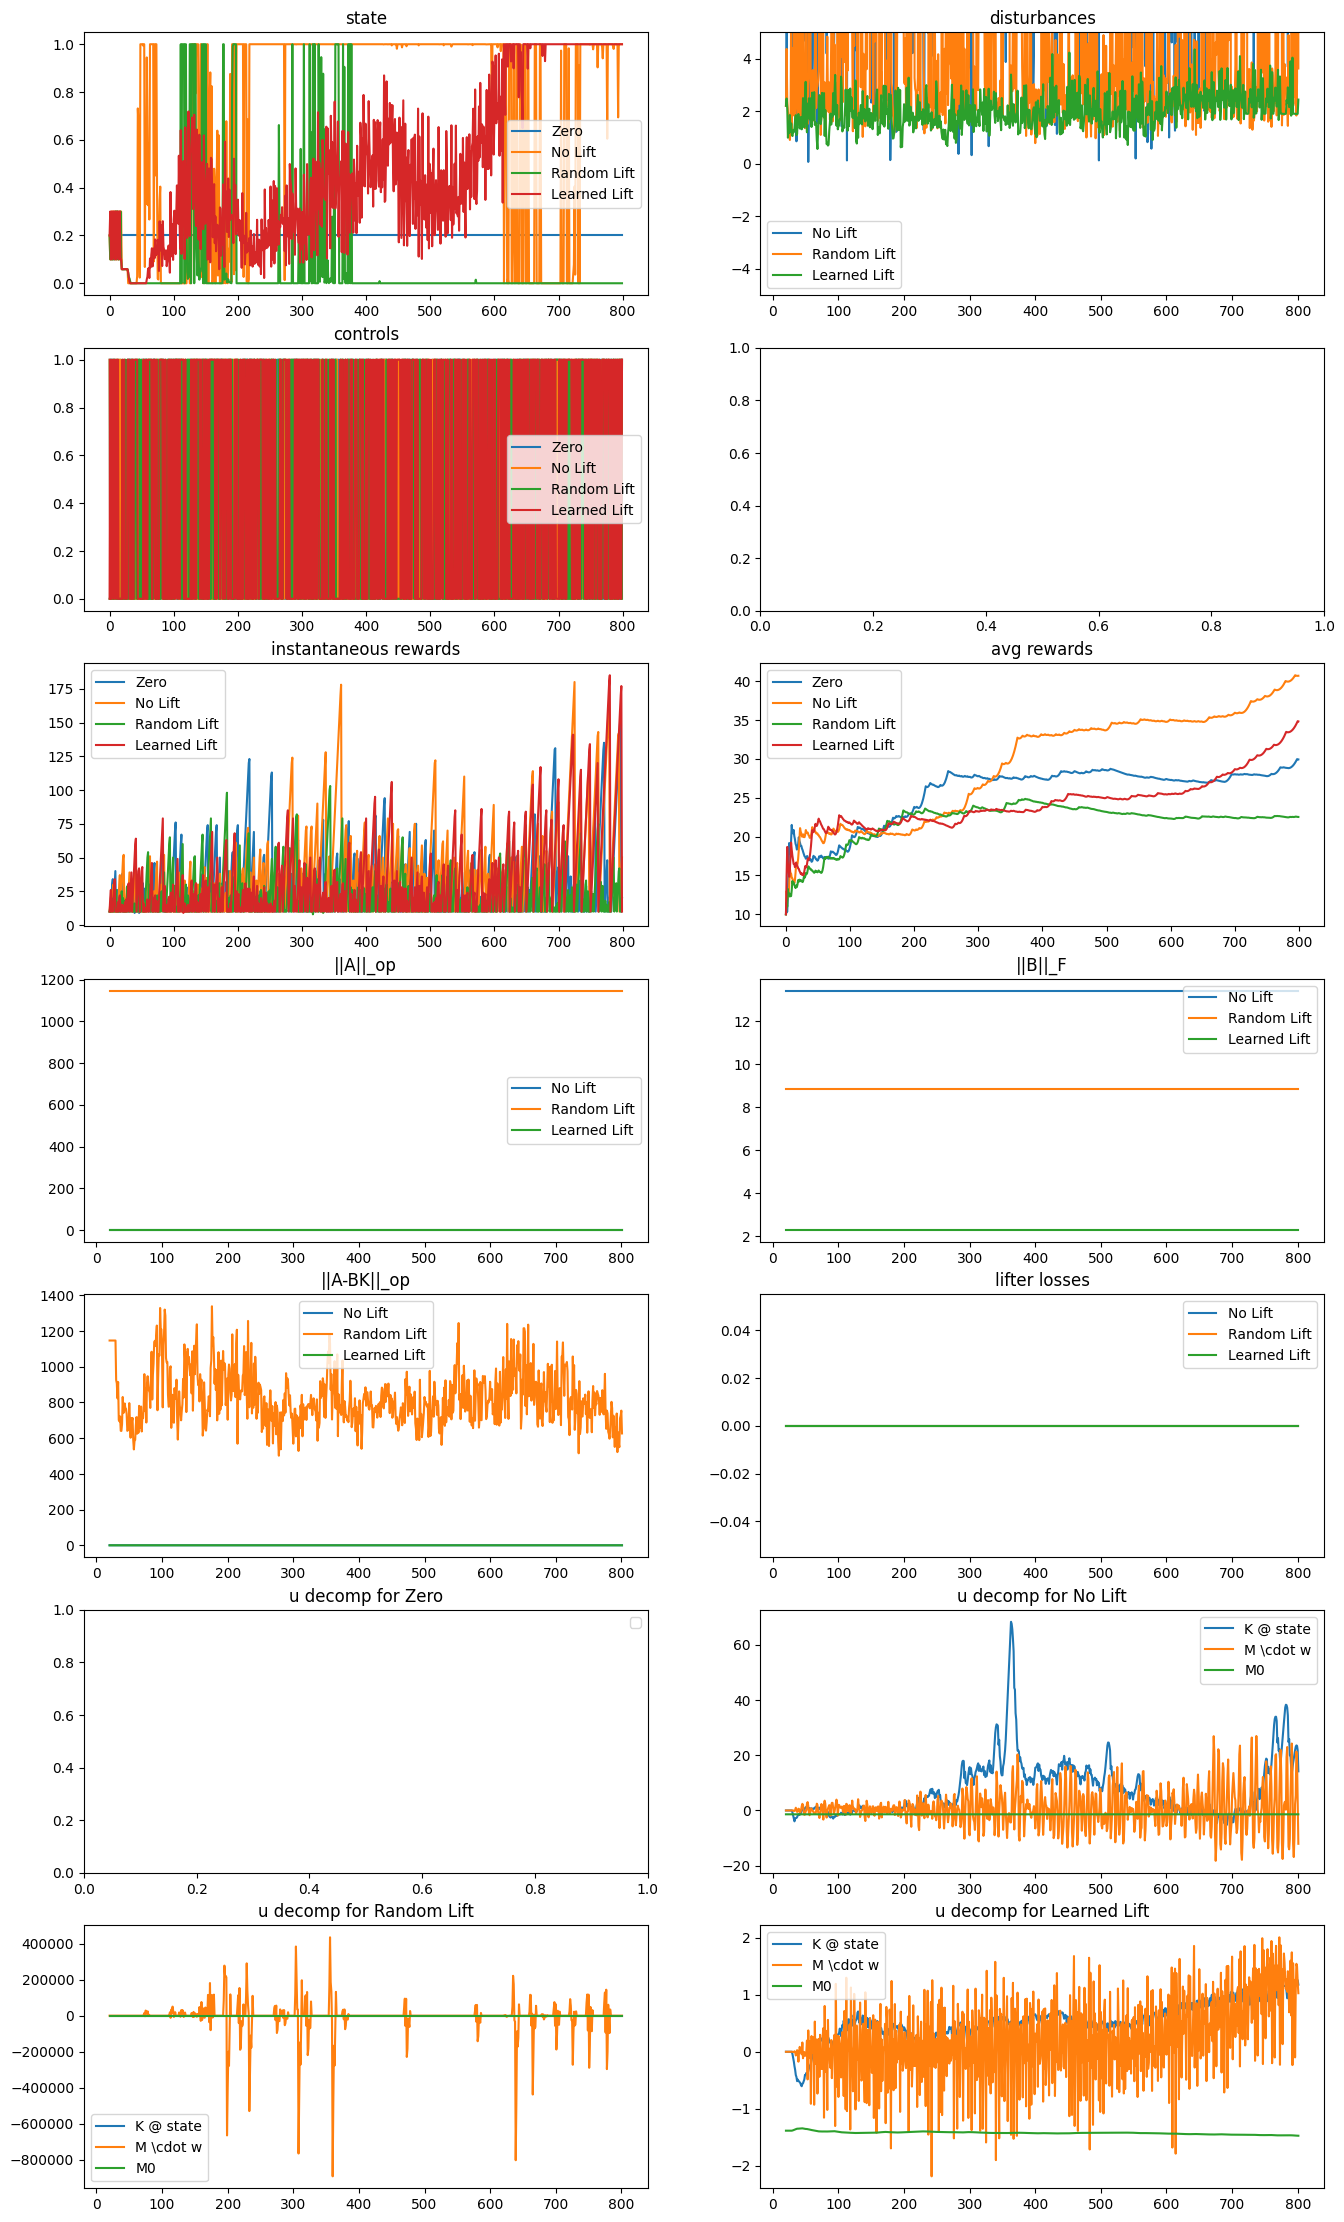

In [4]:
experiment_args = {
    'make_system': make_system,
    'make_controllers': make_controllers,
    'num_trials': num_trials,
    'T': T,
    'reset_every': reset_every,
    'reset_seed': SYSTEM_SEED,
    'wordy': wordy,
    
}
stats = run_experiment(**experiment_args)
plot_ppo(stats)